# Feature Selection & Bayesian Additive Regression Trees
For this Jupyter Notebook, we're using Bayesian Additive Regression Trees to predict which combination of features will give us the highest model performance possible, as well as using Bayesian Regression Models. 

## 1 | Importing Necessary Libraries
The cell below shows the necessary imports of several Python libraries that are commonly used for statistical modeling and data visualization. Here is a short description of each of them as follows:
- **ArviZ (az):** A library for exploratory analysis of Bayesian models.
- **Matplotlib (plt):** A plotting library for creating static, animated, and interactive visualizations in Python.
- **NumPy (np):** A library for numerical computing, providing support for arrays and mathematical functions.
- **Pandas (pd):** A data manipulation library that offers data structures for efficiently storing and analyzing data.
- **PyMC (pm):** A library for probabilistic programming that allows users to build Bayesian models.
- **PyMC-BART (pmb):** An extension for PyMC that implements Bayesian Additive Regression Trees (BART).
- **PyTensor (pt):** A library for symbolic computation used for defining and evaluating mathematical expressions.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import pytensor.tensor as pt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 2 | Visual Styling & Color Cycling
The cell below is used to establish and configure a visual style for the plots created using Matplotlib and sets up a color cycle for the axes. Here are some documentation links that you can refer for future use:
- **For plt.rc():** https://jakevdp.github.io/PythonDataScienceHandbook/04.11-settings-and-stylesheets.html 
- **For ArviZ:** https://python.arviz.org/en/stable/getting_started/Introduction.html#arviz-style-sheets

In [2]:
# using the grayscale style for the UNQILO plots
az.style.use("arviz-grayscale")

# importing the cycler class
from cycler import cycler

# creating a custom color cycle to be applied to all plots 
custom_cycler = cycler(color=["#000000", "#6A6A6A", "#BEBEBE", "#2A2EEC"])

# setting the default color cycle for the axes as well as the default resolution
plt.rc("axes", prop_cycle=custom_cycler)
plt.rc("figure", dpi=500)

# random seed for ensuring reproducibility
np.random.seed(123)

## 3 | Data Handling & Preprocessing
Next up, we perform data preprocessing, where we set which features on the dataset we want to set as the target variable, and which one we want to set as the feature variables. Since we're concerned with predicting which combination of features give the highest model performance, we 

In [3]:
# reading the csv file
feature_df = pd.read_csv("data_for_BART.csv")
feature_df.head(5)

,1,2,3,4,5,6,7,8,9,10,11,12,model_performance
0,0,1,1,1,0,1,1,1,0,1,1,1,0.825517
1,0,0,1,1,0,1,0,0,1,1,0,1,0.816629
2,0,1,0,1,0,1,0,1,0,1,0,0,0.745680
3,1,1,0,0,1,1,1,1,1,0,1,0,0.480339
4,0,0,1,0,1,0,1,0,0,1,1,0,0.549884


In [4]:
# the target variable
Y = feature_df["model_performance"]

# the new dataframe using feature variables
X = feature_df[["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]]

## 4 | Bayesian Regression Model
The cell below runs a Bayesian Regression Model using PyMC and Bayesian Additive Regression Trees (BART) to analyze the stock market performance of the UNIQLO's parent company's stock.

### Code Explanation
This cell below works by learning from data on the model performance for different combinations of features, and allowing for making educated guesses about model performances of new combinations of features. It captures the relationships in the data between the target variables and the feature variables. 

In [20]:
# creating a probabilistic model context using PyMC
with pm.Model() as model_pen:
    σ = pm.HalfNormal("σ", 1)
    μ = pmb.BART("μ", X, Y, m=50)
    y = pm.Normal("y", mu=μ, sigma=σ, observed=Y)

    # sampling process to estimate parameters of the model based on observed data
    idata_pen = pm.sample(random_seed=123)

    # generates new data based on model's learned parameters to see how well it can predict new observations
    preds = pm.sample_posterior_predictive(idata_pen, extend_inferencedata=True, random_seed=123)

    # Extract posterior predictive samples for y
    y_samples = preds.posterior_predictive["y"].values

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 149 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


In [8]:
# retrieving the smallest predicted value of the outcome based on the built model
idata_pen.posterior_predictive.min()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    y        float64 0.256

## 5 | Plotting the Model
The cell below is used to create a plot of the posterior predictive checks (PPC). PPC is important because it helps with assessing how well the Bayesian Model fits the observed data. If the PPC don't align well with the observed data, this indicates that the model isn't adequately capturing relationships in the data.

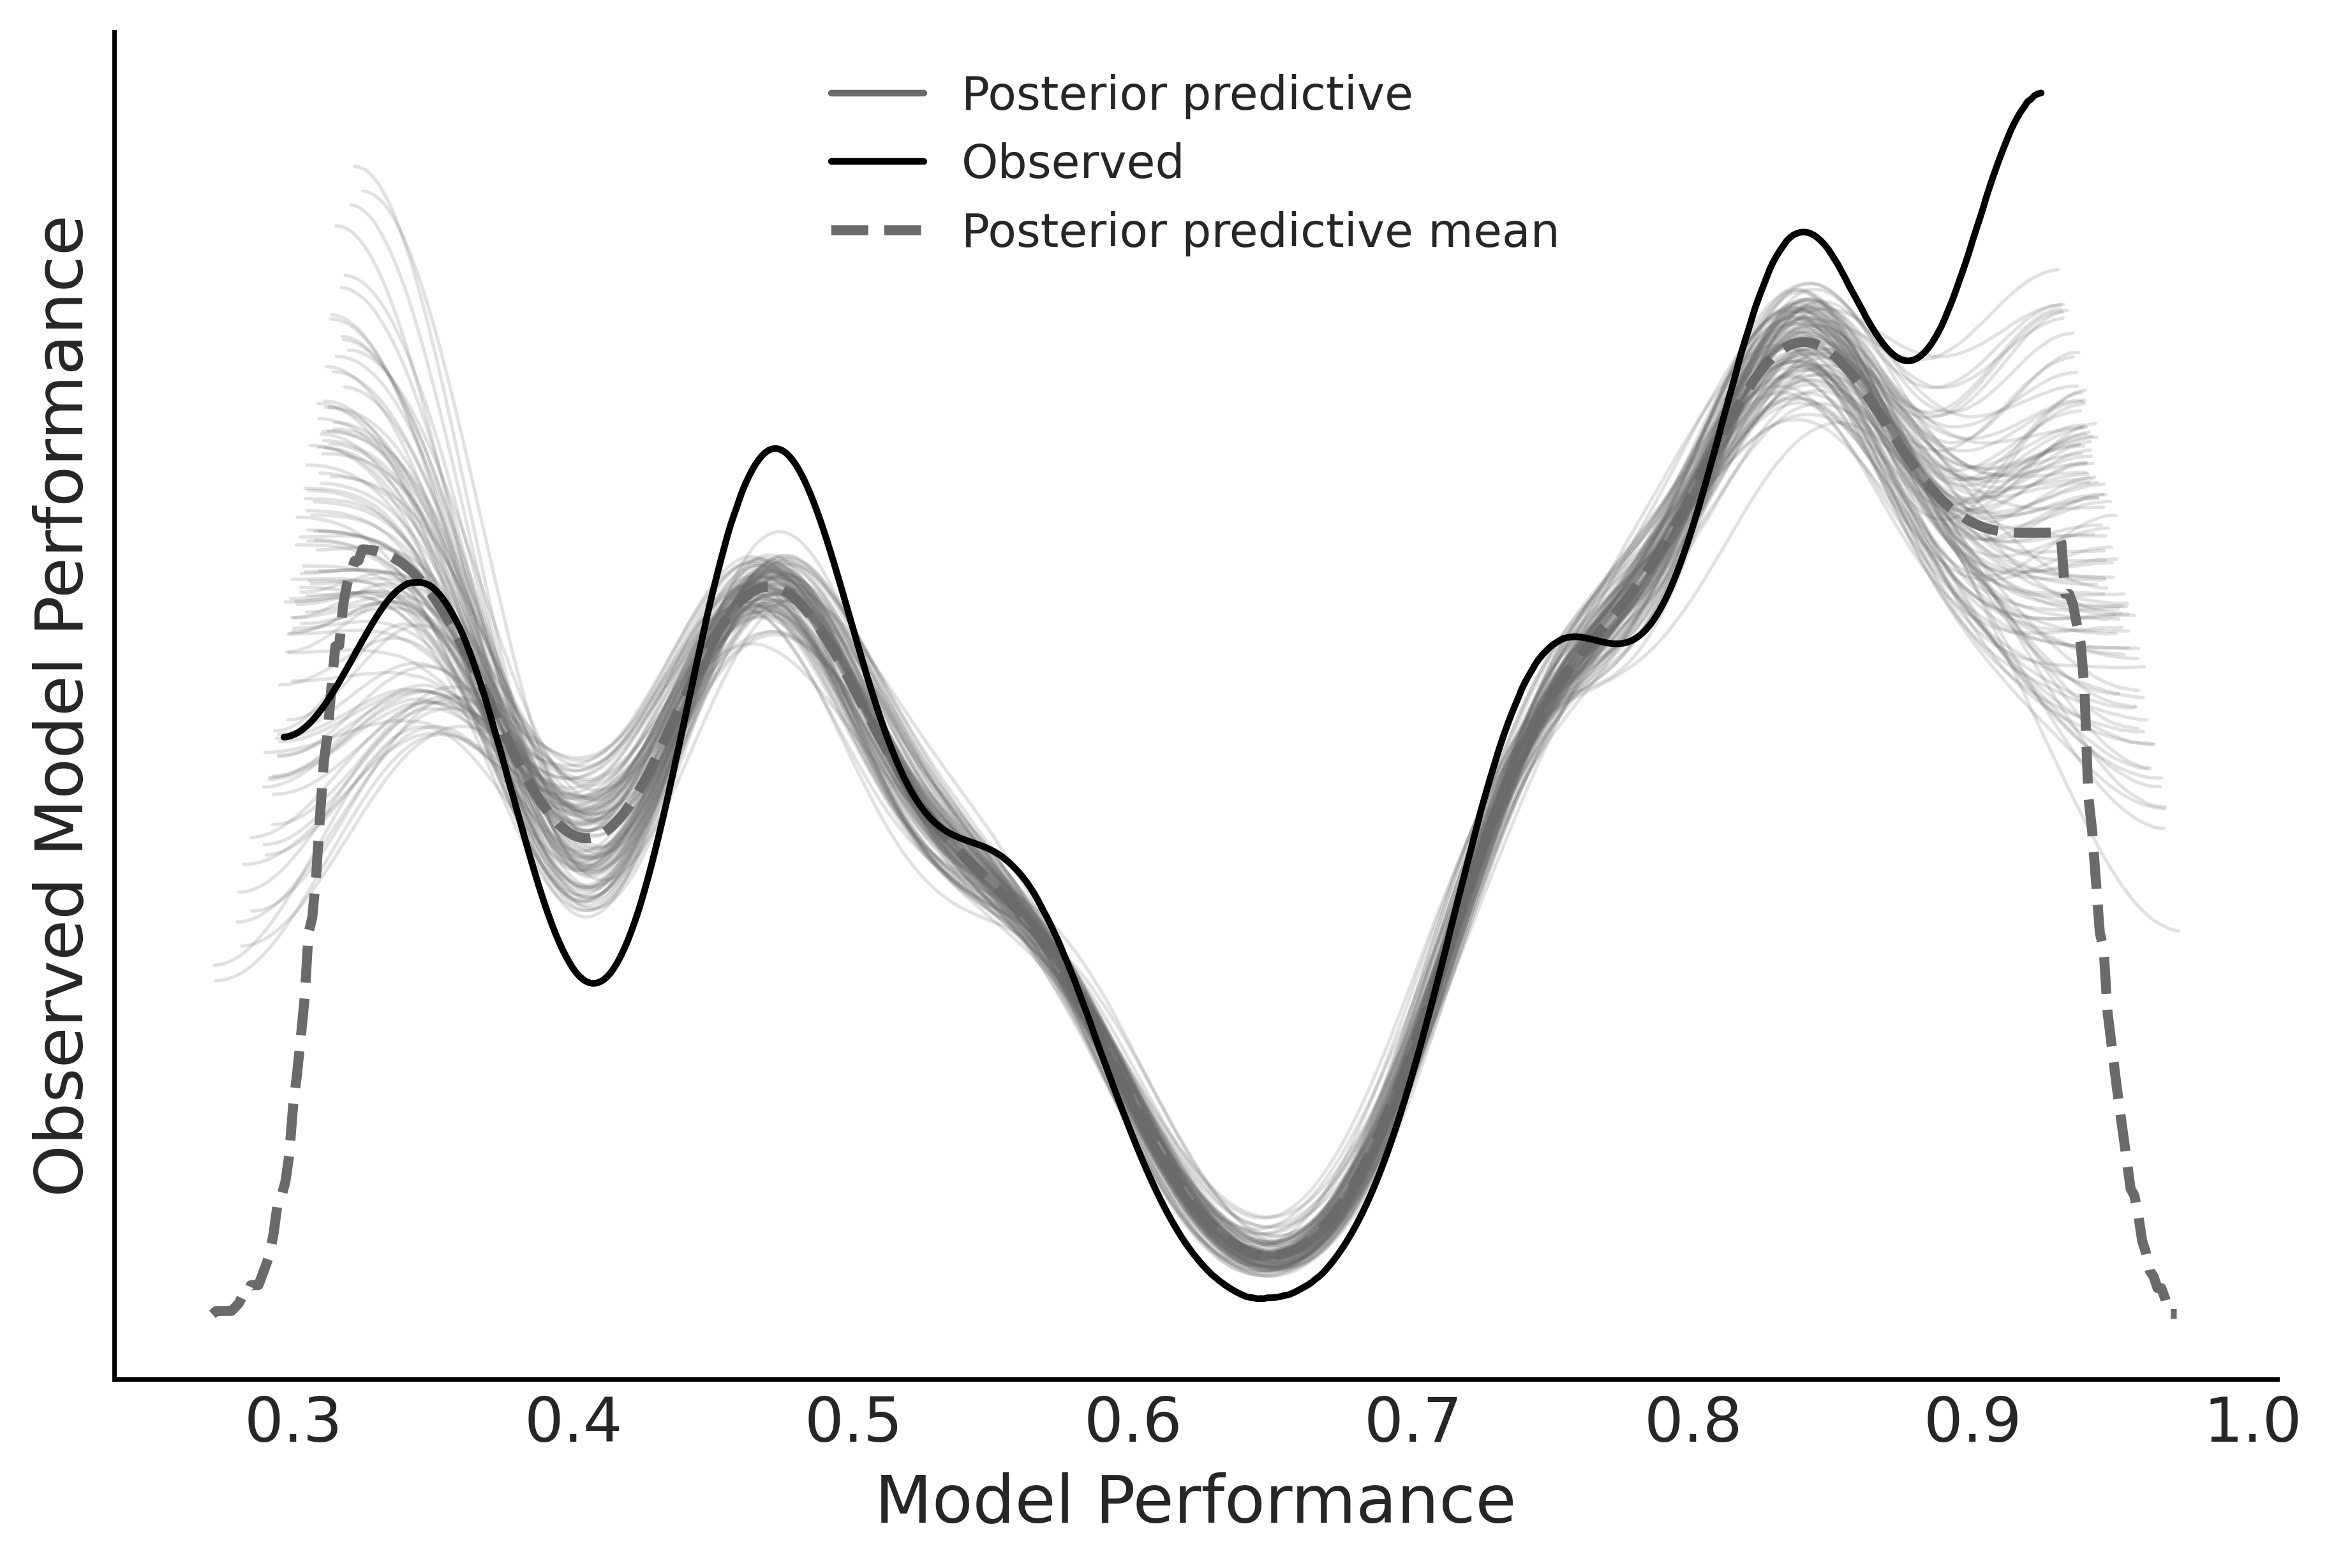

In [9]:
# creating the plot of the posterior predictive checks (PPC)
ax = az.plot_ppc(idata_pen, num_pp_samples=100, colors=["C1", "C0", "C1"])

# setting the x-label and saving the figure
ax.set_xlabel("Model Performance")
ax.set_ylabel("Observed Model Performance")
plt.savefig("model_performance_ppc.png")

## 6 | Partial Dependence Plots
The cell below creates a visual representation of how each input feature affects the closing stock price based on the BART model. Each subplot in the figure corresponds to each input feature, which shows the expected changes in the predicted outcome as that feature varies.

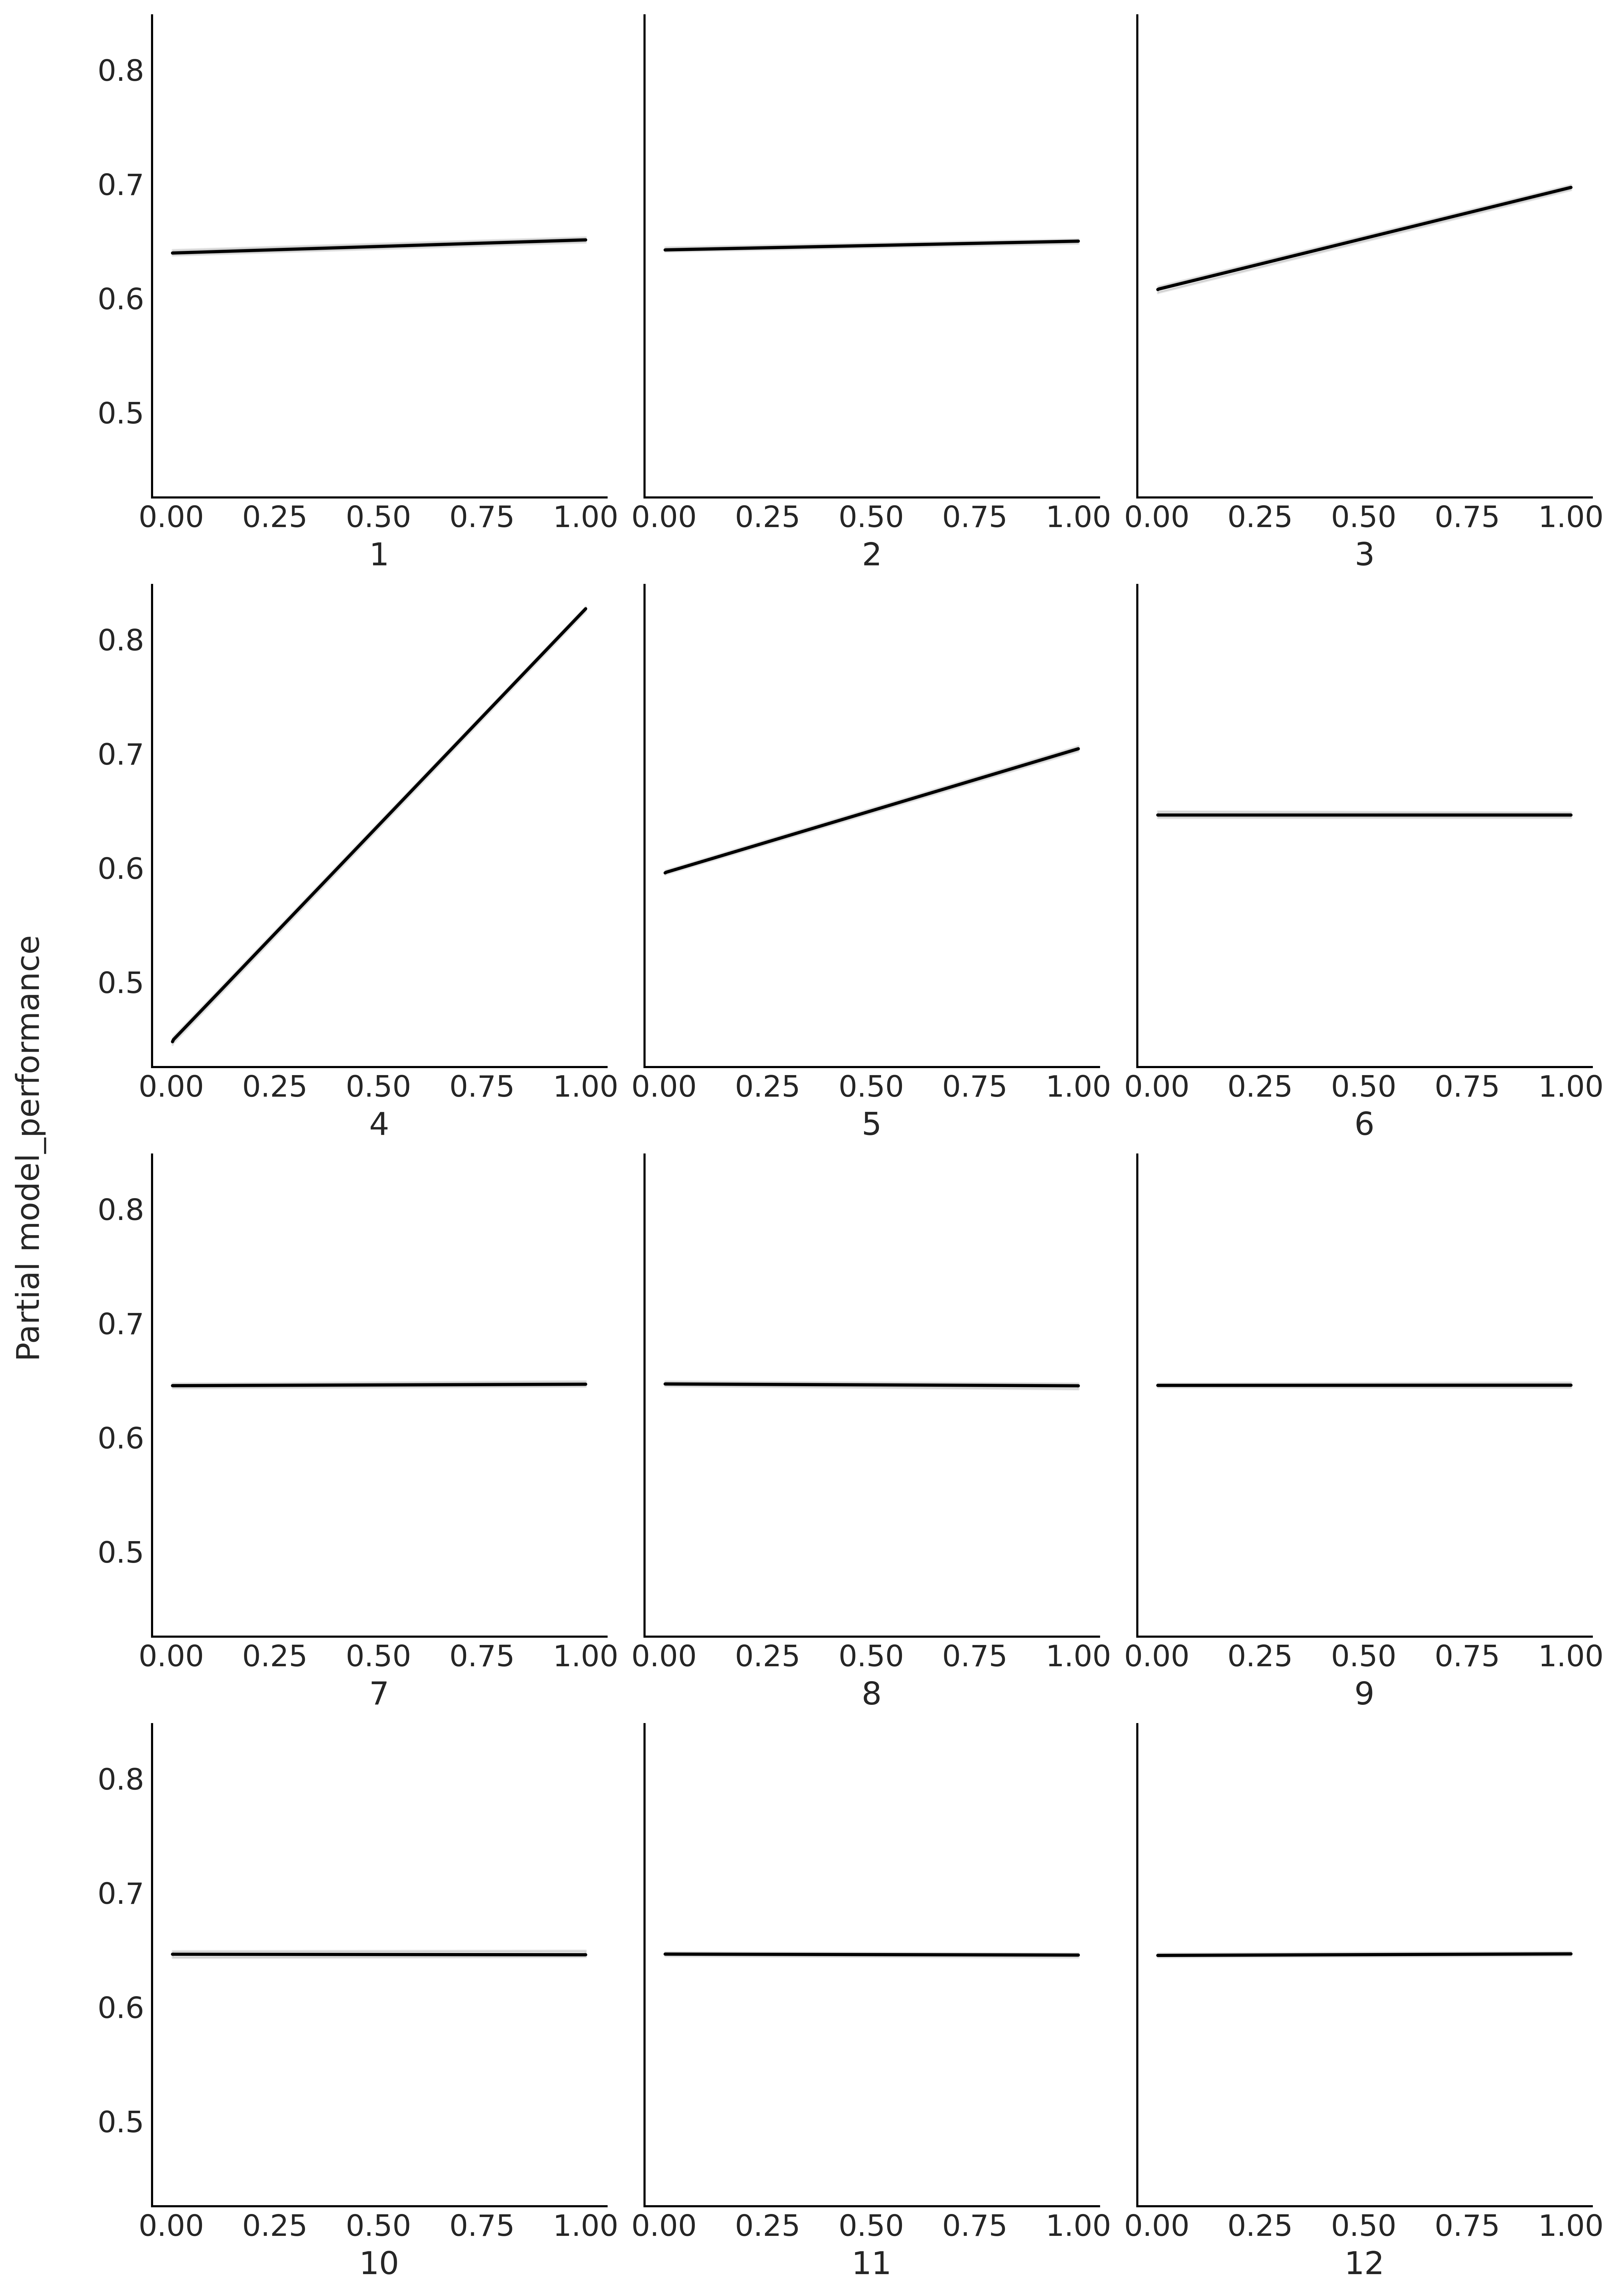

In [10]:
pmb.plot_pdp(μ, X, Y, grid=(4, 3), figsize=(10, 15))
plt.savefig("model_performance_pdp.png", bbox_inches="tight")

In [34]:
# Extract the posterior predictive samples for the target variable
y_samples = preds.posterior_predictive["y"].values

In [43]:
# Function to compute partial dependence
def compute_partial_dependence(model, X, feature_idx, feature_values=None):
    if feature_values is None:
        feature_values = np.linspace(np.min(X.iloc[:, feature_idx]), np.max(X.iloc[:, feature_idx]), 100)
    
    # Copy X to modify the selected feature
    X_fixed = X.copy()
    
    # Array to store the predictions
    y_pred = np.zeros(len(feature_values))
    
    # Loop over the feature values and compute predictions
    for i, value in enumerate(feature_values):
        # Hold all other features constant, modify the feature of interest
        X_fixed.iloc[:, feature_idx] = value
        
        # Get posterior predictions for the modified X_fixed
        with model:
            preds_fixed = pm.sample_posterior_predictive(idata_pen, var_names=["y"], random_seed=123)
        
        y_pred_samples = preds_fixed.posterior_predictive["y"].values
        
        # Compute the mean of posterior predictive samples across the first axis (chain axis)
        y_pred[i] = y_pred_samples.mean(axis=1).mean()  # This averages over the chains and draws
    
    return feature_values, y_pred

compute_partial_dependence(model_pen, X, feature_idx)



In [44]:
# Example usage
feature_idx = 3  # Index of the feature to compute partial dependence for
feature_values, y_pred = compute_partial_dependence(model_pen, X, feature_idx)

# Now you have the feature values and corresponding predicted values for the partial dependence plot
print("Feature values (x):", feature_values)
print("Predicted values (y):", y_pred)

Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Feature values (x): [0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.8787878

## 7 | Partial Dependence Plot Data Extraction
Next, we attempt to extract the data from the partial dependence plots in order to figure out how the data is being plotted, and what the x and y axes stand for, and what they mean in more detail.

**Predicted Response:** model's best guess or estimate of the outcome we're trying to predict

### Understanding Partial Dependence Plots
In a partial dependence plot, the aces represent the following:
- **X-axis:** the feature for which you're analyzing the effect on the model's predictions. Shows the range of values for that specific feature
- **Y-axis:** represents the predicted response for a regression task when it comes to binary classification

In [11]:
print(idata_pen.posterior)  # This will show the tracked variables in the posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, μ_dim_0: 200)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * μ_dim_0  (μ_dim_0) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198 199
Data variables:
    μ        (chain, draw, μ_dim_0) float64 0.8207 0.8205 ... 0.4677 0.8336
    σ        (chain, draw) float64 0.009617 0.009646 ... 0.01051 0.01146
Attributes:
    created_at:                 2024-11-13T12:58:39.034105
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              140.81697177886963
    tuning_steps:               1000


In [12]:
print(idata_pen.posterior["μ"].shape) # 4 chains, 1000 draws, 200 samples

(4, 1000, 200)


In [13]:
print(preds.posterior_predictive.keys())

KeysView(<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, y_dim_2: 200)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * y_dim_2  (y_dim_2) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198 199
Data variables:
    y        (chain, draw, y_dim_2) float64 0.8247 0.8263 ... 0.4519 0.8425
Attributes:
    created_at:                 2024-11-13T12:58:52.014923
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0)


In [14]:
# Initialize a list to store the predicted probabilities (y-values)
pd_values = []

## 8 | Variable Importance
The cell below generates and saves a plot of variable importance for the Bayesian Additive Regression Trees (BART) model. The plots visually shows the relative importance of each input feature in predicting the target variable (close stock price) based on the BART model.

In [17]:
# used to plot the variable importance of each feature in the model
_, axes = pmb.plot_variable_importance(idata_pen, μ, X, figsize=(15, 15))

# sets the y-axis range
axes[0].set_ylim(0, .6)   # first subplot
axes[1].set_ylim(0.7, 1)  # second subplot

# saving diagram as a figure
plt.savefig("model_performance_VI.png")

/usr/local/lib/python3.11/site-packages/pymc_bart/utils.py:786: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  chains_hdi = az.hdi((var_imp_chains.T / var_imp_chains.sum(axis=1)).T)[indices]
